# Anomaly Detection
Perform anomaly detection on a dataset the examines the number of tweets mentioning Facebook in 5 minute intervals.
___
Import the libraries and import the data as a time series. 

In [459]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
plt.style.use('fivethirtyeight')
import datetime
from datetime import date
from sklearn.model_selection import train_test_split

df = pd.read_csv(
    '../data/Twitter_volume_FB.csv',
    index_col='timestamp',
    parse_dates=['timestamp']
)

df.head()

,value
timestamp,
2015-02-26 21:42:53,53
2015-02-26 21:47:53,64
2015-02-26 21:52:53,49
2015-02-26 21:57:53,48
2015-02-26 22:02:53,22


## Exploratory Data Analysis
___
### 1. Show the Number of Tweets Mentioning Facebook Over Time  

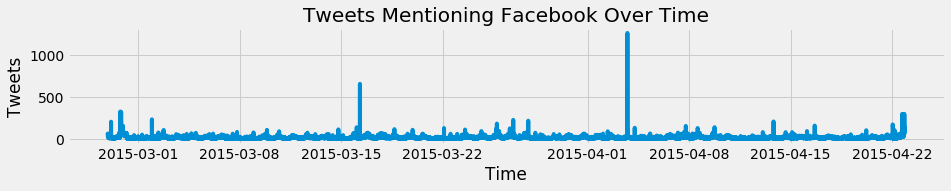

In [460]:
register_matplotlib_converters()
plt.figure(figsize=(14,2))
plt.title("Tweets Mentioning Facebook Over Time")
plt.xlabel("Time")
plt.ylabel("Tweets")
plt.plot(df)

### 2. Show the Number of Tweets For March of 2015

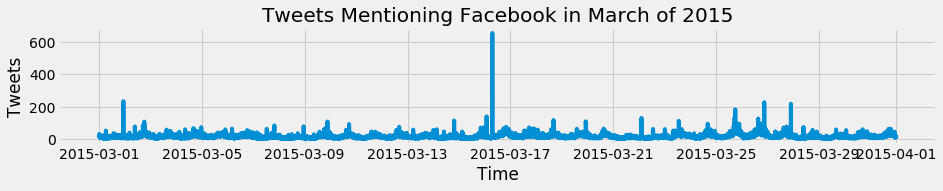

In [461]:
df_month = df.loc[(df.index >= "2015-03-01") & (df.index < "2015-04-01")]
plt.figure(figsize=(14,2))
plt.title("Tweets Mentioning Facebook in March of 2015")
plt.xlabel("Time")
plt.ylabel("Tweets")
plt.plot(df_month)

### 3. Show the Number of Tweets For 3/1/15 - 3/7/15

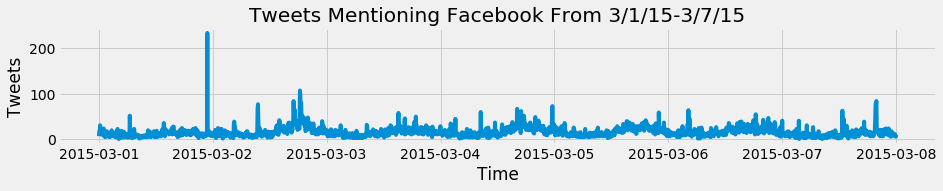

In [462]:
df_week = df.loc[(df.index >= "2015-03-01") & (df.index < "2015-03-08")]
plt.figure(figsize=(14,2))
plt.title("Tweets Mentioning Facebook From 3/1/15-3/7/15")
plt.xlabel("Time")
plt.ylabel("Tweets")
plt.plot(df_week)

### 4. Show the Number of Tweets For 3/1/15

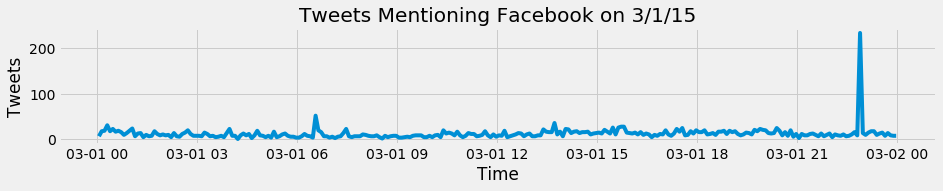

In [463]:
df_day = df.loc[(df.index >= "2015-03-01") & (df.index < "2015-03-02")]
plt.figure(figsize=(14,2))
plt.title("Tweets Mentioning Facebook on 3/1/15")
plt.xlabel("Time")
plt.ylabel("Tweets")
plt.plot(df_day)

**Conclusions:** There does not appear to be any seasonality in this time series, and spikes do not seem to follow a pattern.

## Anomaly Detection
___

Create a function that plots the calculated outliers on top of the line graph.

In [464]:
def plotOutliers(df_outliers, methodName):
    fig, ax = plt.subplots(figsize=(14,2))
    ax.set(
        xlabel="Time",
        ylabel="Tweets",
        title="Tweets Mentioning Facebook Over Time"
    )
    ax.plot(df.index, df.value, zorder=0)
    ax.scatter(df_outliers.index, df_outliers.value, c="#ff9900" , marker=",", zorder=1)
    print(methodName)
    print("Number of Anomalies: " + str(df_outliers.shape[0]))
    print("Percentage of Anomalies: %d / %d = %4.4f" % (df_outliers.shape[0], df.shape[0], (df_outliers.shape[0]/df.shape[0])))
    print("\nAnomalies shown as orange dots below:")

### 1. Interquartile Range
Calculate the interquartile range (IQR). Outliers are values that are less than (q1 - 1.5*IQR) or greater than (q3 + 1.5*IQR).

#### Display the IQR in a box plot.

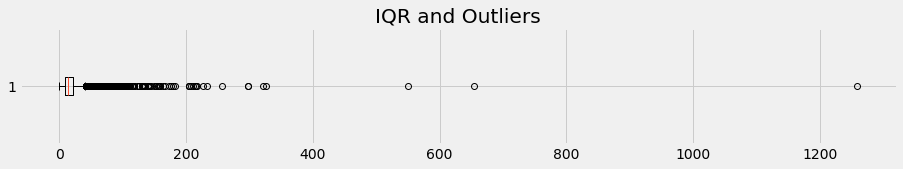

In [465]:
fig1, ax1 = plt.subplots(figsize=(14,2))
ax1.set_title("IQR and Outliers")
ax1.boxplot(df["value"], whis=1.5, vert=False)
plt.show()

#### Display the IQR values

In [466]:
q3, q1 = np.percentile(df['value'], [75 ,25])
iqr = q3 - q1
dfMedian = df['value'].median()
print("25th Percentile: " + str(q1))
print("75th Percentile: " + str(q3))
print("Interquartile Range: " + str(iqr))
print("Median: " + str(dfMedian))

print("\nOutliers:")
print("    (Q1 - 1.5*IQR) < non-outliers < (Q3 + 1.5*IQR) =")
print("        " + str(q1 - 1.5 * iqr) + "      < non-outliers <      " + str(q3 + 1.5 * iqr))

25th Percentile: 9.0
75th Percentile: 22.0
Interquartile Range: 13.0
Median: 14.0

Outliers:
    (Q1 - 1.5*IQR) < non-outliers < (Q3 + 1.5*IQR) =
        -10.5      < non-outliers <      41.5


Plot the IQR outliers.

IQR:
Number of Anomalies: 788
Percentage of Anomalies: 788 / 15833 = 0.0498

Anomalies shown as orange dots below:


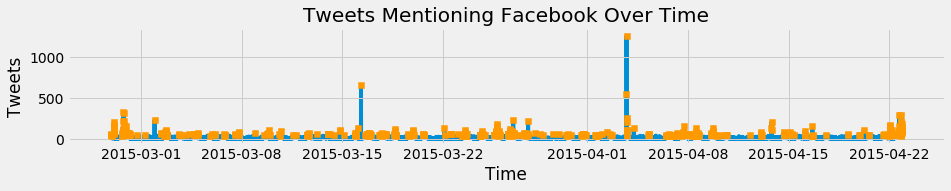

In [467]:
df_outliers = df.loc[df.value >= q3 + 1.5 * iqr]
plotOutliers(df_outliers, "IQR:")

**Conclusion:** there are many outliers when using IQR, considering the normal amount of tweets about Facebook is low.

### 1. Isolation Forest
Use an isolation forest with an outlier percentage of .5% and .1%.

#### Using an outlier percentage of .5%: 

Isolation Forest (.5% Contamination):
Number of Anomalies: 78
Percentage of Anomalies: 78 / 15833 = 0.0049

Anomalies shown as orange dots below:


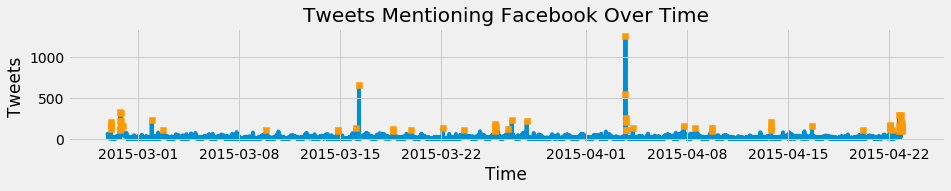

In [468]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=.005, behaviour="new")
model.fit(df)

df["anomaly"] = model.predict(df)
df_outliers = df.loc[df.anomaly == -1]

plotOutliers(df_outliers, "Isolation Forest (.5% Contamination):")

#### Using an outlier percentage of .1%:

Isolation Forest (.1% Contamination):
Number of Anomalies: 13
Percentage of Anomalies: 13 / 15833 = 0.0008

Anomalies shown as orange dots below:


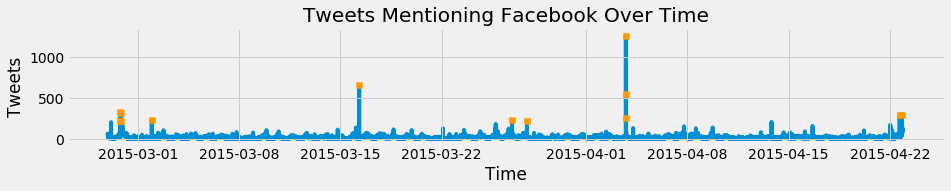

In [469]:
model = IsolationForest(contamination=.001, behaviour="new")
model.fit(df)

df["anomaly"] = model.predict(df)
df_outliers = df.loc[df.anomaly == -1]

plotOutliers(df_outliers, "Isolation Forest (.1% Contamination):")


**Conclusions:**
- Isolation forests allow us to customize our outlier percentage, which gives us the opportunity to focus on the most extreme anomalies.

Display the Outliers:

In [470]:
df_outliers

,value,anomaly
timestamp,,
2015-02-27 18:32:53,216,-1
2015-02-27 18:37:53,326,-1
2015-02-27 19:57:53,322,-1
2015-02-27 20:02:53,214,-1
2015-03-01 22:52:53,233,-1
2015-03-16 07:07:53,654,-1
2015-03-26 20:52:53,227,-1
2015-03-27 21:42:53,217,-1
2015-04-03 17:42:53,550,-1


Lump together the outliers by day:

In [471]:
df_outliers_daily = df_outliers.resample("D").sum()
df_outliers_daily.loc[df_outliers_daily.value > 0]

,value,anomaly
timestamp,,
2015-02-27,1078,-4
2015-03-01,233,-1
2015-03-16,654,-1
2015-03-26,227,-1
2015-03-27,217,-1
2015-04-03,2065,-3
2015-04-22,595,-2


**Conclusion**: something signifigant with Facebook likely happened on these days, but I could not find any news articles from these days.

## Possible Feature Engineering
___
Add the average hourly value and average daily value to the dataframe. Since averages are affected by outliers, this might improve our model.

In [472]:
df_hourly = df.resample("H").mean()
df_hourly.head()

,value,anomaly
timestamp,,
2015-02-26 21:00:00,53.500000,1.0
2015-02-26 22:00:00,31.833333,1.0
2015-02-26 23:00:00,27.333333,1.0
2015-02-27 00:00:00,18.666667,1.0
2015-02-27 01:00:00,15.166667,1.0


In [473]:
df_daily = df.resample("D").mean()
df_daily.head()

,value,anomaly
timestamp,,
2015-02-26,33.000000,1.000000
2015-02-27,37.451389,0.972222
2015-02-28,22.208333,1.000000
2015-03-01,12.690972,0.993056
2015-03-02,19.579861,1.000000


Insert the average hourly/daily values into the dataframe.

In [474]:
del df["anomaly"]

# Put hourly average value into df
df_copy = df.copy()
df_copy["timestamp_hourly"] = df_copy.index.floor("H")
df_copy
df_copy = df_copy.merge(df_hourly, how='inner', left_on='timestamp_hourly', right_on='timestamp')
df_copy
df["hourly_avg_value"] = list(df_copy["value_y"])

# Put daily average value into df
df_copy = df.copy()
df_copy["timestamp_daily"] = df_copy.index.floor("D")
df_copy
df_copy = df_copy.merge(df_daily, how='inner', left_on='timestamp_daily', right_on='timestamp')
df_copy
df["daily_avg_value"] = list(df_copy["value_y"])
df.head()

,value,hourly_avg_value,daily_avg_value
timestamp,,,
2015-02-26 21:42:53,53,53.500000,33.0
2015-02-26 21:47:53,64,53.500000,33.0
2015-02-26 21:52:53,49,53.500000,33.0
2015-02-26 21:57:53,48,53.500000,33.0
2015-02-26 22:02:53,22,31.833333,33.0


Plot the Isolation forest that is fit with the dataframe that includes average daily/hourly values.

Isolation Forest (.1% Contamination):
Number of Anomalies: 16
Percentage of Anomalies: 16 / 15833 = 0.0010

Anomalies shown as orange dots below:


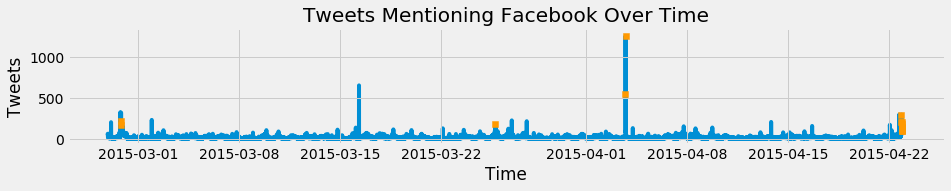

In [475]:
model = IsolationForest(contamination=.001, behaviour="new")
model.fit(df)

df["anomaly"] = model.predict(df)
df_outliers = df.loc[df.anomaly == -1]

plotOutliers(df_outliers, "Isolation Forest (.1% Contamination):")

**Conclusions:**
- Adding daily/hourly average values prevented us from predicting the anomaly around 3/15/2015. This is likely due to the fact that the spike in tweets was so brief that the average hourly/daily rate was still normal.
- This prevented us from predicting some anomalies because the regular hourly/daily rate overshadowed the 5-minute interval spike.

## Final Conclusion:
#### Isolation forest, unlike IQR, allows the user to customize what percent of the dataset they want to deem outliers, which allows them to minimize the outliers as they see fit.